In [18]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from dataset import AfricanWildlifeDataset
from loss import YoloLoss
from YOLOv1 import YOLOv1
from train import train
from test import test
from utils import plot_bbox, compute_ap, get_boxes

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 5
EPOCHS = 10
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 7, 2, 4

## Loading data

In [3]:
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

## Training

In [4]:
model = YOLOv1(input_channels=3, S=S, B=B, C=C).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss()


In [5]:
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, load_model=True, save_epochs=5)


-> Loading checkpoint


100%|██████████| 60/60 [00:30<00:00,  2.00it/s, loss=0.0305]


 EPOCH 1:  Mean loss 0.027


100%|██████████| 60/60 [00:30<00:00,  1.96it/s, loss=0.0338]


 EPOCH 2:  Mean loss 0.031


100%|██████████| 60/60 [00:28<00:00,  2.08it/s, loss=0.0336]


 EPOCH 3:  Mean loss 0.028


100%|██████████| 60/60 [00:29<00:00,  2.07it/s, loss=0.0273]


 EPOCH 4:  Mean loss 0.023


100%|██████████| 60/60 [00:28<00:00,  2.09it/s, loss=0.017] 


 EPOCH 5:  Mean loss 0.021
-> Saving checkpoint


100%|██████████| 60/60 [00:29<00:00,  2.06it/s, loss=0.0174]


 EPOCH 6:  Mean loss 0.016


100%|██████████| 60/60 [00:30<00:00,  1.94it/s, loss=0.0206]


 EPOCH 7:  Mean loss 0.014


100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.0126] 


 EPOCH 8:  Mean loss 0.013


100%|██████████| 60/60 [00:29<00:00,  2.07it/s, loss=0.0147] 


 EPOCH 9:  Mean loss 0.011


100%|██████████| 60/60 [00:29<00:00,  2.07it/s, loss=0.014]  

 EPOCH 10:  Mean loss 0.011


Text(0, 0.5, 'Loss')

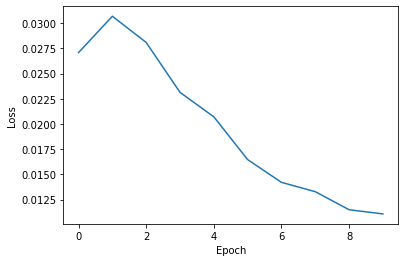

In [6]:
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Testing

In [7]:
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.6, True])

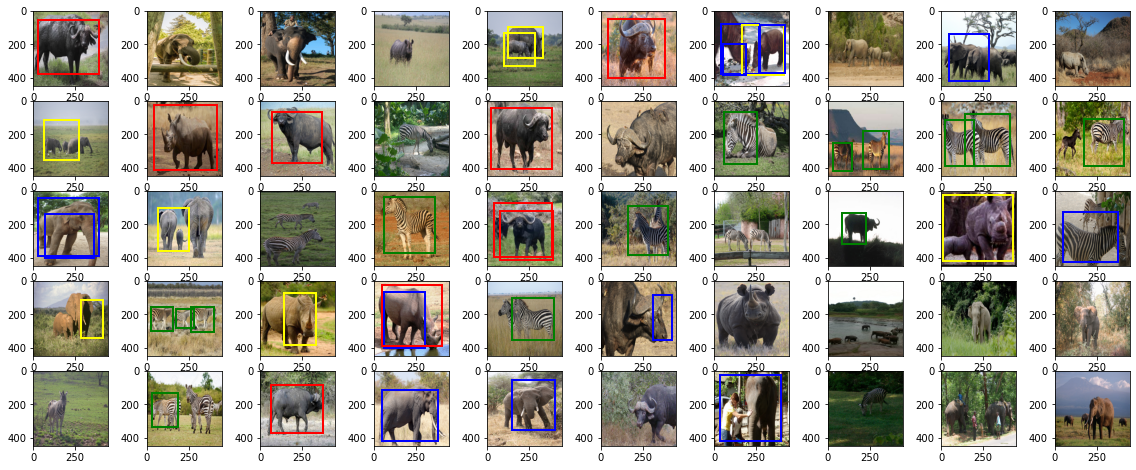

In [8]:
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
for idx in range(50):
    bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

### Non-max suppression

In [30]:
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

In [31]:
pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

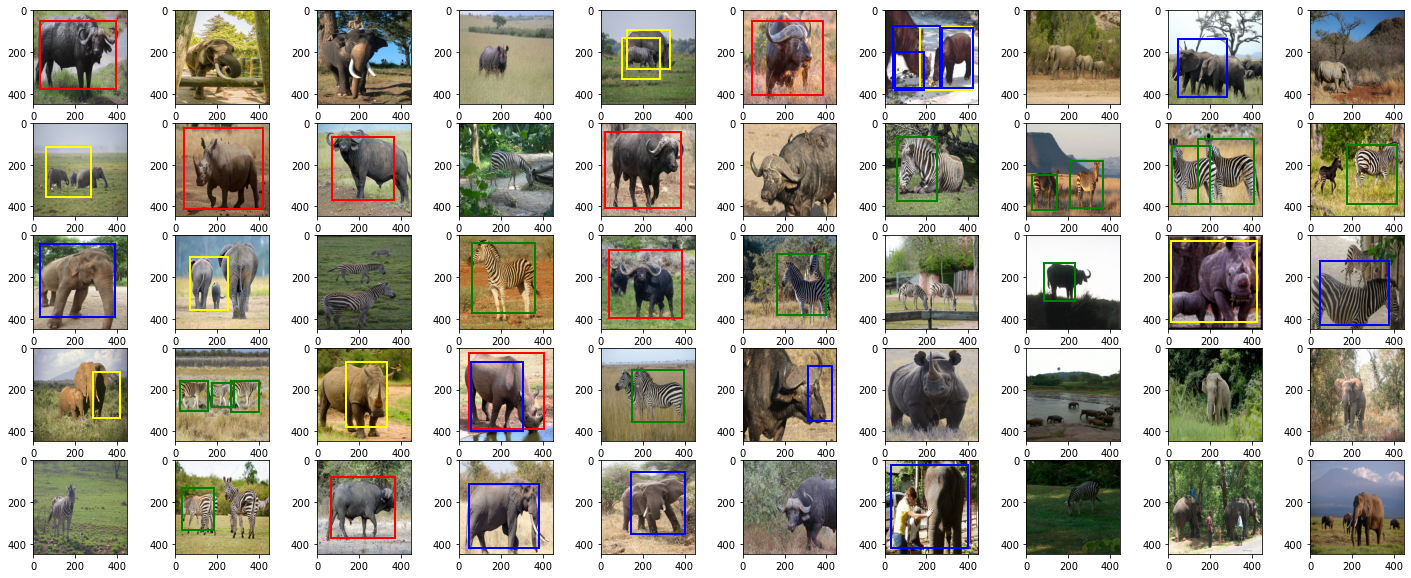

In [32]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [33]:
# mean_average_precision = compute_ap(pred_boxes, true_boxes, iou_threshold=0.5)
# print(mean_average_precision)

In [34]:
color_map = {'buffalo': "red", 'elephant': "blue", 'rhino': "yellow", 'zebra': "green"}

In [35]:
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])

## mean average precision (mAP)

In [36]:
def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [37]:
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

In [38]:
th = [0.1, 0.25, 0.5, 0.75]
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)

In [39]:
m_ap.update(predictions, target)
ap = m_ap.compute()

In [40]:
ap

{'map': tensor(0.2021),
 'map_50': tensor(0.1829),
 'map_75': tensor(0.0381),
 'map_small': tensor(0.2021),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.2153),
 'mar_10': tensor(0.2495),
 'mar_100': tensor(0.2495),
 'mar_small': tensor(0.2495),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}